## Observations and Insights 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
# Merge on the mouse_metadata file because that holds the record of all the mice, eliminates any mice that were not originally in the meta data
merged_df = pd.merge(mouse_metadata, study_results, how="left", on="Mouse ID")

# Display the data table for preview
merged_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:
# Checking the number of mice by counting the number of unique ID's in the data set
merged_df["Mouse ID"].nunique()

249

In [3]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint.
# Use duplicated() function to find duplicate values in the Mouse ID and Timepoint columns, 
# set keep to False to keep all duplicate values in the new data frame
duplicate_mice_df = merged_df[merged_df.duplicated(["Mouse ID", "Timepoint"], keep=False)]

# Display all the data for the duplicate mice
duplicate_mice_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [4]:
# Optional: Get all the data for the duplicate mouse ID.

# Create a new data frame to hold all the data for rows and columns where the duplicate mouse appears from above
all_duplicates = merged_df.loc[merged_df["Mouse ID"]=="g989"]

# Display the data
all_duplicates

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
# First we will create a new data frame with the Mouse ID as the index
clean_data = merged_df.set_index("Mouse ID")

# Use the drop() function to select the index value of the Mouse ID we want to remove from the data and remove it
clean_data = clean_data.drop(index="g989")

# Display the cleaned data, 1880 rows should remain since 13 rows were removed for Mouse ID g989
clean_data = clean_data.reset_index()

# Display the data frame
clean_data

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1875,z969,Naftisol,Male,9,30,25,63.145652,2
1876,z969,Naftisol,Male,9,30,30,65.841013,3
1877,z969,Naftisol,Male,9,30,35,69.176246,4
1878,z969,Naftisol,Male,9,30,40,70.314904,4


In [6]:
# Checking the number of mice in the clean DataFrame.
# There should only be 248 unique mice left after we removed one with duplicate entries
total_mice = clean_data["Mouse ID"].nunique()
total_mice

248

## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen.
# This method is the most straighforward, creating multiple series and putting them all together at the end.

# First groupby() Drug Regimen
drug_group = clean_data.groupby("Drug Regimen")

# Set a variable equal to the Tumor Volume column
drug_group_tumor = drug_group["Tumor Volume (mm3)"]

# Calculate mean
drug_mean = drug_group_tumor.mean()

# Calculate median
drug_median = drug_group_tumor.median()

# Calculate variance
drug_variance = drug_group_tumor.var()

# Calculate standard deviation
drug_std_dev = drug_group_tumor.std()

# Calculate standard error of the mean
drug_SEM = drug_group_tumor.sem()

# Create a summary table with appropriate headers and values
drug_summary = pd.DataFrame({"Mean Tumor Volume" : drug_mean,
                             "Median Tumor Volume" : drug_median,
                             "Tumor Volume Variance" : drug_variance,
                             "Tumor Volume Std. Dev." : drug_std_dev,
                             "Tumor Volume Std. Err." : drug_SEM})

# Display the summary table
drug_summary

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method produces everything in a single groupby function.

# Create a data frame that is groupby() Drug Regimen and uses the agg() function to perform the stat calculations on the Tumor Volume column
drug_summary_table = clean_data.groupby("Drug Regimen").agg({"Tumor Volume (mm3)" : ["mean", "median", "var", "std", "sem"]})

# Display the summary table
drug_summary_table

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

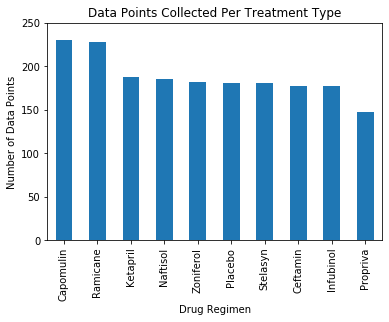

In [9]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas.

# Since we are looking at the data throughout the course of the study, I will assume we are looking at all the data points per mouse in each treatment.
# Using this assumption, we first get the number of data points but using the count() function on the data frame grouped by Drug Regimen earlier
number_of_mice = drug_group.count()

# Create a new data frame by selecting any column as all of the counts will be the same for a groupby() data frame
# Since we used groupby() earlier, the index has already been set to be the Drug Regimen
number_of_mice = number_of_mice[["Mouse ID"]]

# Sort the data in descending values so the bar chart is easier to read
sorted_data_points = number_of_mice.sort_values("Mouse ID", ascending=False)

# Use DataFrame.plot() to create a bar chart
sorted_data_points.plot(kind="bar", legend=None, title="Data Points Collected Per Treatment Type", ylim=[0,250])

# Add a label for the y axis using matplotlib since pandas does not have a parameter for that
plt.ylabel("Number of Data Points");
plt.show()

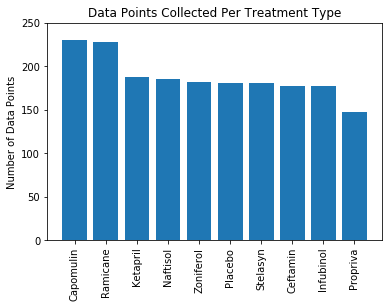

In [10]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.

# Reset the index and create a data frame with columns Drug Regimen and Mouse ID
sorted_df = sorted_data_points.reset_index()

# Calculate the length of the x axis to create tick locations
x_axis = range(len(sorted_df))
tick_locations = [value for value in x_axis]

# Create the bar chart where x_axis is the number of bars with a y axis representing the number of data points and the bars centered on the x coordinates
plt.bar(x_axis, sorted_df["Mouse ID"], align="center")

# Add the Drug Regiment names for the x ticks, make them vertical for better appearance
# Add ";" to the end of the command to suppress the "matplotlib.axis.XTick" list of locations to keep output clean
plt.xticks(tick_locations, sorted_df["Drug Regimen"], rotation="vertical");

# Add a label for the y axis and title, set the limit for the y axis to 250
plt.ylabel("Number of Data Points");
plt.title("Data Points Collected Per Treatment Type");
plt.ylim(top=250)
plt.show()

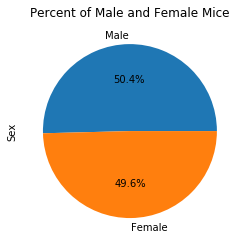

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

# groupby() Sex to get the number of unique male and female mice
mice_gender = clean_data.groupby("Sex").nunique()

# Create a data frame that only has the unique values for Mouse ID based on sex in descending order
mice_gender_df = mice_gender[["Mouse ID"]].sort_values("Mouse ID", ascending=False)

# Create and display the pie plot, set y label
mice_gender_df.plot(kind="pie", y="Mouse ID", title="Percent of Male and Female Mice", autopct="%1.1f%%", legend=None).set_ylabel("Sex");
plt.show()

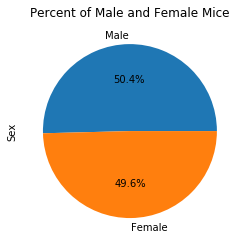

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

# Reset the index so we can use the columns
mice_gender_reset = mice_gender_df.reset_index()

# Create and display the pie plot, add title, add y label
plt.pie(mice_gender_reset["Mouse ID"], labels=mice_gender_reset["Sex"], autopct="%1.1f%%");
plt.title("Percent of Male and Female Mice");
plt.ylabel("Sex");
plt.show()

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
# groupby() Mouse ID to create a new data frame
# Get the greatest timepoint by finding the max value for each mouse
mouse_group = clean_data.groupby("Mouse ID")["Timepoint"].max()

# Create a new data frame with the index set to Mouse ID
greatest_timepoint_df = pd.DataFrame(mouse_group)

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
greatest_timepoint_merged = pd.merge(greatest_timepoint_df, clean_data, how="left", on="Mouse ID", suffixes=("_greatest","_original"))

# Create a data frame filtering for only the rows that match the greatest timepoint found above by matching it to the original timepoints
greatest_timepoint_tumor_vol = greatest_timepoint_merged.loc[greatest_timepoint_merged["Timepoint_original"] == greatest_timepoint_merged["Timepoint_greatest"]]

# Delete the extra timepoint column
del greatest_timepoint_tumor_vol["Timepoint_greatest"]

# Use isin() to create a data frame that only includes the rows/columns where the 4 treatments are found
treatments = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
selected_treatments = greatest_timepoint_tumor_vol[greatest_timepoint_tumor_vol["Drug Regimen"].isin(treatments)]

# Reset the index and drop the old index that is saved as a column
selected_treatments.reset_index(drop=True)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint_original,Tumor Volume (mm3),Metastatic Sites
0,a203,Infubinol,Female,20,23,45,67.973419,2
1,a251,Infubinol,Female,21,25,45,65.525743,1
2,a275,Ceftamin,Female,20,28,45,62.999356,3
3,a411,Ramicane,Male,3,22,45,38.407618,1
4,a444,Ramicane,Female,10,25,45,43.047543,0
...,...,...,...,...,...,...,...,...
95,y769,Ceftamin,Female,6,27,45,68.594745,4
96,y793,Capomulin,Male,17,17,45,31.896238,2
97,y865,Ceftamin,Male,23,26,45,64.729837,3
98,z578,Ramicane,Male,11,16,45,30.638696,0


In [19]:
# Create an empty data frame to store the Tumor Volume of each treatment type in separate columns
treatment_list = pd.DataFrame()

# Loop through each treatment type in the treatments list
for drug in treatments:

    # Create a new data frame that includes only the specified treatment (drug) and all of the corresponding rows and columns
    new_df = selected_treatments.loc[selected_treatments["Drug Regimen"] == drug]

    # Add a column with the treatment (drug) name to the empty data frame with the values of Tumor Volume for that treatment type
    treatment_list[f"{drug}"] = new_df["Tumor Volume (mm3)"].to_list()

    # Calculate the quartiles, IQR, and bounds
    quartiles = new_df["Tumor Volume (mm3)"].quantile([.25, .5, .75])
    lowerq = quartiles[.25]
    upperq = quartiles[.75]
    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)

    # Print out the calculations in a readable format
    print("\n\n")
    print(f"Treatment Type: {drug}")
    print("--------------------------------------------------------------------")
    print(f"The lower quartile of tumor volume is: {lowerq}")
    print(f"The upper quartile of tumor volume is: {upperq}")
    print(f"The interquartile range of tumor volume is: {iqr}")
    print(f"The the median of tumor volume is: {quartiles[0.5]} ")
    print(f"Values below {lower_bound} could be outliers for tumor volume.")
    print(f"Values above {upper_bound} could be outliers for tumor volume.")

    # Determine the outliers using the upper and lower bounds
    outliers = new_df.loc[(new_df["Tumor Volume (mm3)"] < lower_bound) | (new_df["Tumor Volume (mm3)"] > upper_bound)]

    # If there are no outliers, print a statement saying there are no outliers
    if outliers.empty:
        print(f"There are no outliers for {drug} in the data.")

    # If there are outliers, display a data frame containing all of the outliers for the treatment (drug) type
    else:
        print(f"The following are outliers for {drug} in the data: \n" )
        display(outliers)




Treatment Type: Capomulin
--------------------------------------------------------------------
The lower quartile of tumor volume is: 32.37735684
The upper quartile of tumor volume is: 40.1592203
The interquartile range of tumor volume is: 7.781863460000004
The the median of tumor volume is: 38.125164399999996 
Values below 20.70456164999999 could be outliers for tumor volume.
Values above 51.83201549 could be outliers for tumor volume.
There are no outliers for Capomulin in the data.



Treatment Type: Ramicane
--------------------------------------------------------------------
The lower quartile of tumor volume is: 31.56046955
The upper quartile of tumor volume is: 40.65900627
The interquartile range of tumor volume is: 9.098536719999998
The the median of tumor volume is: 36.56165229 
Values below 17.912664470000003 could be outliers for tumor volume.
Values above 54.30681135 could be outliers for tumor volume.
There are no outliers for Ramicane in the data.



Treatment Type: In

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint_original,Tumor Volume (mm3),Metastatic Sites
275,c326,Infubinol,Female,18,25,5,36.321346,0





Treatment Type: Ceftamin
--------------------------------------------------------------------
The lower quartile of tumor volume is: 48.72207785
The upper quartile of tumor volume is: 64.29983003
The interquartile range of tumor volume is: 15.577752179999997
The the median of tumor volume is: 59.85195552 
Values below 25.355449580000002 could be outliers for tumor volume.
Values above 87.66645829999999 could be outliers for tumor volume.
There are no outliers for Ceftamin in the data.


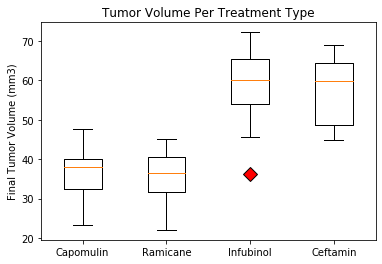

In [15]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
data = [treatment_list["Capomulin"], treatment_list["Ramicane"], treatment_list["Infubinol"], treatment_list["Ceftamin"]]
fig1, ax1 = plt.subplots()
ax1.set_title("Tumor Volume Per Treatment Type")
ax1.set_ylabel("Final Tumor Volume (mm3)")
ax1.set_xticklabels(treatments)
red_diamond = dict(markerfacecolor="red", marker="D", markersize=10)
ax1.boxplot(data, flierprops=red_diamond);
plt.show()

## Line and Scatter Plots

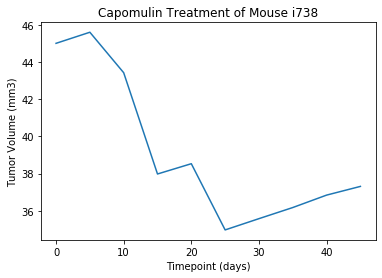

In [16]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
# Get a data frame made up of mice that were treated with Capomulin
single_mouse = clean_data[clean_data["Drug Regimen"].isin(["Capomulin"])]

# Generate a list of unique Mouse ID's to view and pick a mouse to evaluate, commented out because it's only being used to pick a mouse
# single_mouse_list = single_mouse["Mouse ID"].unique()
# single_mouse_list

selected_mouse = "i738"

# Create lists to plot
single_mouse_time = single_mouse.loc[single_mouse["Mouse ID"] == selected_mouse]["Timepoint"].to_list()
single_mouse_tumor = single_mouse.loc[single_mouse["Mouse ID"] == selected_mouse]["Tumor Volume (mm3)"].to_list()

# Plot the line plot
plt.plot(single_mouse_time, single_mouse_tumor)
plt.title(f"Capomulin Treatment of Mouse {selected_mouse}");
plt.ylabel("Tumor Volume (mm3)");
plt.xlabel("Timepoint (days)");
plt.show()

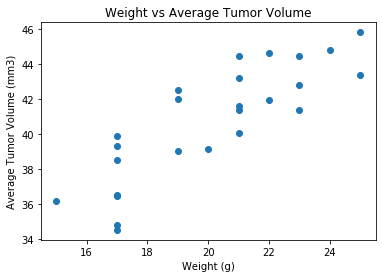

In [17]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
# Create a groupby() on Mouse ID and get the first weight item for each Mouse ID and add it to a list
mice_capomulin_weight = single_mouse.groupby("Mouse ID")["Weight (g)"].first().to_list()

# Creat a groupby() on Mouse ID and get the average Tumor Volume for each Mouse ID and add it to a list
mice_capomulin_tumor_avg = single_mouse.groupby("Mouse ID")["Tumor Volume (mm3)"].mean().to_list()

plt.scatter(mice_capomulin_weight, mice_capomulin_tumor_avg)
plt.title("Weight vs Average Tumor Volume");
plt.ylabel("Average Tumor Volume (mm3)");
plt.xlabel("Weight (g)");
plt.show()

## Correlation and Regression

The correlation between mouse weight and average tumor volume is 0.84



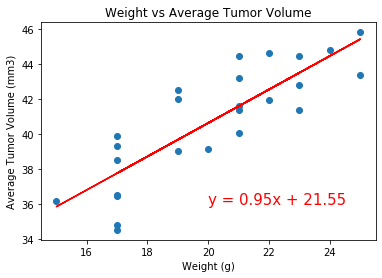

In [18]:
# Calculate the correlation coefficient and linear regression model
# for mouse weight and average tumor volume for the Capomulin regimen
correlation = round(st.pearsonr(mice_capomulin_weight, mice_capomulin_tumor_avg)[0],2)

print(f"The correlation between mouse weight and average tumor volume is {correlation}\n")

x_values = np.array(mice_capomulin_weight)
y_values = np.array(mice_capomulin_tumor_avg)
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values);
plt.plot(x_values,regress_values,"r-");
plt.annotate(line_equation,(20,36),fontsize=15,color="red");
plt.title("Weight vs Average Tumor Volume");
plt.ylabel("Average Tumor Volume (mm3)");
plt.xlabel("Weight (g)");
plt.show()